<img src="https://whatcar.vn/media/2018/09/car-lot-940x470.jpg"/>

## Прогнозирование стоимости автомобиля по характеристикам


> **Контекст задачи.** 
Комания занимается продажей автомобилей с прегом в Москве. Основная задача компании и ее менеджеров - максимально быстро находить выгодные предложения.
>
>
> **Задача.** 
Создание модели для предсказания стоимости автомобиля по его характеристикам.
>
>
>**Проблема.** 
Для обучения модели есть только необольшой датасет, недостаточный для обучения модели.

По условию, нам нужно самостоятельно собрать обучающий датасет. Было собрано порядка 77000 записей с сайта auto.ru  на ноябрь 2021.

In [1]:
#Data

import numpy as np
import pandas as pd 
import sys
import datetime as DT
import pandas_profiling
from pandas import Series

# Models 
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, MinMaxScaler
import category_encoders as ce
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV

from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import (RandomForestRegressor, BaggingRegressor, ExtraTreesRegressor, 
GradientBoostingRegressor, StackingRegressor)

# Time 
import datetime


#Visuals
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#### Функции

In [2]:
def cut_off_stat_outliers(data, column):
    """
    Определение и отсечение выбросов в распределении числовых признаков, на основе IQR
    """
    
     #вычисляем межквартильный размах:
    iqr = data[column].quantile(0.75) - data[column].quantile(0.25)

    #25-й перцентиль:
    perc25 = data[column].quantile(0.25)
    #75-й перцентиль:
    perc75 = data[column].quantile(0.75)

    #верхняя граница выбросов:
    l = perc75 + 1.5*iqr
    #нижняя граница выбросов:
    f = perc25 - 1.5*iqr
    
    #считаем количество выбросов
    print('Количество выбросов:', column, ':',
         data[data[column]<(perc25-1.5*iqr)][column].count() +
          data[data[column]>(perc75+1.5*iqr)][column].count())
    
    print('Верхняя граница выбросов:',
          l, 'Нижняя граница выбросов:', f)

    #всё что выпадает за границы выбросов, заменяем на граничное значение
    data[column] = data[column].apply(lambda m: f if m < f else m)
    data[column] = data[column].apply(lambda m: l if m > l else m)

     
def get_boxplot(data, column, target):
    """
    отрисовкая боксплота для числового признака
    """
    fig, ax = plt.subplots(figsize = (14, 4))
    sns.boxplot(x=column, y=target, 
                data=data.loc[data.loc[:, column].isin(data.loc[:, column].value_counts().index)],
                ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Боксплот: ' + column)
    plt.show()
    
#Обработка типов кузова
def get_types(type):
    if type in ['кабриолет', 'купе', 'купе-хардтоп', 'родстер', 'тарга', 'фастбек']:
        return 'gt'
    if type in ['компактвэн', 'микровэн', 'минивэн', 'универсал']:
        return 'family'
    if type == 'внедорожник':
        return 'suv'
    if type in ['седан', 'седан-хардтоп']:
        return 'sedan'
    if type in ['хэтчбек', 'лифтбек']:
        return 'hatch'
    if type in ['пикап', 'фургон']:
        return 'truck'
    if type == 'лимузин':
        return 'premium'
    else:
        return type

In [3]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)

Python       : 3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]
Numpy        : 1.19.2


In [4]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [5]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [6]:
# мерило качества работы моделей

def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

# Setup

In [7]:
VAL_SIZE   = 0.20  

# Data

In [8]:
train = pd.read_csv('data_train_final.csv') # датасет для обучения модели
test = pd.read_csv('test_6.csv') # датасет для валидации моделиа

C:\Users\ElenaS\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [9]:
sample_submission = pd.read_csv('sample_submission_6.csv')

In [10]:
train.head(5)

Unnamed: 0       color  car_price  mileage  productionDate  brand  \
0           0  коричневый    1840000    30000            2018  Skoda   
1           1      чёрный    1640000    80000            2017  Skoda   
2           2       синий     320000   168000            2005  Skoda   
3           3       серый     800000   170000            2012  Skoda   
4           4  коричневый    1570000     5000            2020  Skoda   

  model_name bodyType engineDisplacement  enginePower fuelType       sell_id  \
0    octavia  лифтбек                  2          184   Дизель  1.105830e+09   
1     superb  лифтбек                  2          190   Дизель  1.103512e+09   
2    octavia  лифтбек                  2          115   Бензин  1.105757e+09   
3    octavia  лифтбек                1.9          105   Дизель  1.105957e+09   
4      rapid  лифтбек                1.6          110   Бензин  1.105881e+09   

  vehicleTransmission    Владельцы       ПТС    Привод   Руль  \
0    роботизированная    1владелец  Оригинал    полный  Левый   
1    роботизированная    1владелец  Оригинал    полный  Левый   
2        механическая  3 или более  Оригинал  передний  Левый   
3    роботизированная   2владельца  Оригинал  передний  Левый   
4      автоматическая    1владелец  Оригинал  передний  Левый   

            Состояние  
0  Не требует ремонта  
1  Не требует ремонта  
2  Не требует ремонта  
3  Не требует ремонта  
4  Не требует ремонта

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77529 entries, 0 to 77528
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           77529 non-null  int64  
 1   color                77529 non-null  object 
 2   car_price            77529 non-null  int64  
 3   mileage              77529 non-null  int64  
 4   productionDate       77529 non-null  int64  
 5   brand                77529 non-null  object 
 6   model_name           77529 non-null  object 
 7   bodyType             77529 non-null  object 
 8   engineDisplacement   77529 non-null  object 
 9   enginePower          77529 non-null  int64  
 10  fuelType             77529 non-null  object 
 11  sell_id              77529 non-null  float64
 12  vehicleTransmission  77529 non-null  object 
 13  Владельцы            77529 non-null  object 
 14  ПТС                  77529 non-null  object 
 15  Привод               77529 non-null 

In [12]:
test.head(5)

bodyType  brand                                            car_url  \
0  лифтбек  SKODA  https://auto.ru/cars/used/sale/skoda/octavia/1...   
1  лифтбек  SKODA  https://auto.ru/cars/used/sale/skoda/octavia/1...   
2  лифтбек  SKODA  https://auto.ru/cars/used/sale/skoda/superb/11...   
3  лифтбек  SKODA  https://auto.ru/cars/used/sale/skoda/octavia/1...   
4  лифтбек  SKODA  https://auto.ru/cars/used/sale/skoda/octavia/1...   

        color                                 complectation_dict  \
0       синий                                                NaN   
1      чёрный                                                NaN   
2       серый  {"id":"20026336","name":"Ambition","available_...   
3  коричневый  {"id":"20803582","name":"Ambition","available_...   
4       белый                                                NaN   

                                         description engineDisplacement  \
0  Все автомобили, представленные в продаже, прох...            1.2 LTR   
1  ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...            1.6 LTR   
2  Все автомобили, представленные в продаже, прох...            1.8 LTR   
3  КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...            1.6 LTR   
4  ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...            1.8 LTR   

  enginePower                                     equipment_dict fuelType  \
0     105 N12  {"engine-proof":true,"tinted-glass":true,"airb...   бензин   
1     110 N12  {"cruise-control":true,"asr":true,"esp":true,"...   бензин   
2     152 N12  {"cruise-control":true,"tinted-glass":true,"es...   бензин   
3     110 N12  {"cruise-control":true,"roller-blind-for-rear-...   бензин   
4     152 N12  {"cruise-control":true,"asr":true,"esp":true,"...   бензин   

   ...     vehicleConfiguration  vehicleTransmission    vendor    Владельцы  \
0  ...       LIFTBACK ROBOT 1.2     роботизированная  EUROPEAN  3 или более   
1  ...  LIFTBACK MECHANICAL 1.6         механическая  EUROPEAN   1 владелец   
2  ...       LIFTBACK ROBOT 1.8     роботизированная  EUROPEAN   1 владелец   
3  ...   LIFTBACK AUTOMATIC 1.6       автоматическая  EUROPEAN   1 владелец   
4  ...   LIFTBACK AUTOMATIC 1.8       автоматическая  EUROPEAN   1 владелец   

  Владение       ПТС    Привод   Руль           Состояние     Таможня  
0      NaN  Оригинал  передний  Левый  Не требует ремонта  Растаможен  
1      NaN  Оригинал  передний  Левый  Не требует ремонта  Растаможен  
2      NaN  Оригинал  передний  Левый  Не требует ремонта  Растаможен  
3      NaN  Оригинал  передний  Левый  Не требует ремонта  Растаможен  
4      NaN  Оригинал  передний  Левый  Не требует ремонта  Растаможен  

[5 rows x 32 columns]

In [13]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

тестовая выборка демонстрирует около 35000 значений, по условию валидационная выборка составляет 20%  от всего набора, значит, общий набор данных в идеале должен бы быть около 175000 значений.  

In [14]:
test.vehicleTransmission.value_counts()

автоматическая      19596
механическая         7209
вариатор             3999
роботизированная     3882
Name: vehicleTransmission, dtype: int64

## Data Preprocessing

Перед тем, как соединить все выборки, обработаем признак цены:

#### 'car_price'

Первое - внесем поправку на рост цен, воспользовавшись данными автостата. 
Второе - выполним округление, поскольку цены на авто округляются, как минимум до целых тысяч.

In [15]:
test.parsing_unixtime.apply(lambda s: datetime.datetime.fromtimestamp(s).strftime('%Y-%m')).unique()

array(['2020-10'], dtype=object)

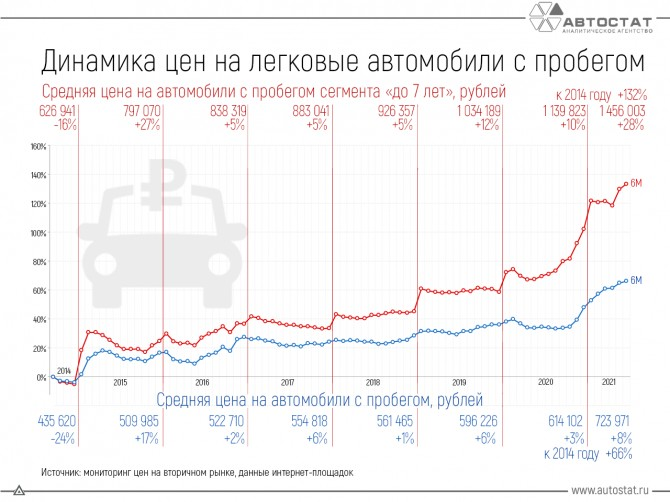

In [16]:
train['car_price'] = train['car_price'].apply(lambda x: round(x /1.28, -3))

в тестовом датасете цены вообще нет, мы должны ее предсказать, так что создадим ее, равной 0

In [17]:
test['car_price'] = 0

### Соединение

Соединим обучающую и тестовую выборки, добавив соответствующий признак:

In [18]:
#добавляем признак выборки,  1 для тренировочной и 0 для тестовой
train['sample'] = 1
test['sample'] = 0

In [19]:
# соединяем
data = pd.concat([test, train], ignore_index=True)

In [20]:
# построим семпл-табличку 
data_agg = data.agg({'nunique', lambda s: s.unique()[:10]})\
    .append(pd.Series(data.isnull().sum(), name='null'))\
    .append(pd.Series(data.dtypes, name='dtype'))\
    .transpose()
data_agg

<lambda>  \
bodyType              [лифтбек, внедорожник 5 дв., хэтчбек 5 дв., се...   
brand                 [SKODA, AUDI, HONDA, VOLVO, BMW, NISSAN, INFIN...   
car_url               [https://auto.ru/cars/used/sale/skoda/octavia/...   
color                 [синий, чёрный, серый, коричневый, белый, пурп...   
complectation_dict    [nan, {"id":"20026336","name":"Ambition","avai...   
description           [Все автомобили, представленные в продаже, про...   
engineDisplacement    [1.2 LTR, 1.6 LTR, 1.8 LTR, 2.0 LTR, 1.4 LTR, ...   
enginePower           [105 N12, 110 N12, 152 N12, 200 N12, 102 N12, ...   
equipment_dict        [{"engine-proof":true,"tinted-glass":true,"air...   
fuelType              [бензин, дизель, гибрид, электро, газ,  Дизель...   
image                 [https://autoru.naydex.net/o9DBXQ270/5ac010hAY...   
mileage               [74000, 60563, 88000, 95000, 58536, 172000, 10...   
modelDate             [2013.0, 2017.0, 2008.0, 2009.0, 2016.0, 2012....   
model_info            [{"code":"OCTAVIA","name":"Octavia","ru_name":...   
model_name            [OCTAVIA, SUPERB, OCTAVIA_RS, YETI, KODIAQ, RA...   
name                  [1.2 AMT (105 л.с.), 1.6 MT (110 л.с.), DSG 1....   
numberOfDoors                            [5.0, 4.0, 2.0, 3.0, 0.0, nan]   
parsing_unixtime      [1603226273.0, 1603226277.0, 1603226280.0, 160...   
priceCurrency                                                [RUB, nan]   
productionDate        [2014, 2017, 2012, 2011, 2019, 2018, 2010, 202...   
sell_id               [1100575026.0, 1100549428.0, 1100658222.0, 110...   
super_gen             [{"id":"10373605","displacement":1197,"engine_...   
vehicleConfiguration  [LIFTBACK ROBOT 1.2, LIFTBACK MECHANICAL 1.6, ...   
vehicleTransmission   [роботизированная, механическая, автоматическа...   
vendor                                        [EUROPEAN, JAPANESE, nan]   
Владельцы             [3 или более, 1 владелец, 2 владельца, 1владел...   
Владение              [nan, 3 года и 2 месяца, 11 месяцев, 4 года и ...   
ПТС                                           [Оригинал, Дубликат, nan]   
Привод                                       [передний, полный, задний]   
Руль                                                    [Левый, Правый]   
Состояние                      [Не требует ремонта, Битый / не на ходу]   
Таможня                                               [Растаможен, nan]   
car_price             [0.0, 1438000.0, 1281000.0, 250000.0, 625000.0...   
sample                                                           [0, 1]   
Unnamed: 0            [nan, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, ...   

                     nunique    null    dtype  
bodyType                  24       0   object  
brand                     23       0   object  
car_url                34686   77529   object  
color                     16       0   object  
complectation_dict      2364  105797   object  
description            31732   77529   object  
engineDisplacement       160       0   object  
enginePower              673       0   object  
equipment_dict         23705   87525   object  
fuelType                  13       0   object  
image                  34557   77529   object  
mileage                11494       0    int64  
modelDate                 66   77529  float64  
model_info               954   77529   object  
model_name               967       0   object  
name                    2780   77529   object  
numberOfDoors              5   77529  float64  
parsing_unixtime       34686   77529  float64  
priceCurrency              1   77529   object  
productionDate            76       0    int64  
sell_id                98785       0  float64  
super_gen               5890   77529   object  
vehicleConfiguration     634   77529   object  
vehicleTransmission        4       0   object  
vendor                     2   77529   object  
Владельцы                  5       0   object  
Владение                 275  100220   object  
ПТС               

In [21]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112215 entries, 0 to 112214
Data columns (total 35 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   bodyType              112215 non-null  object 
 1   brand                 112215 non-null  object 
 2   car_url               34686 non-null   object 
 3   color                 112215 non-null  object 
 4   complectation_dict    6418 non-null    object 
 5   description           34686 non-null   object 
 6   engineDisplacement    112215 non-null  object 
 7   enginePower           112215 non-null  object 
 8   equipment_dict        24690 non-null   object 
 9   fuelType              112215 non-null  object 
 10  image                 34686 non-null   object 
 11  mileage               112215 non-null  int64  
 12  modelDate             34686 non-null   float64
 13  model_info            34686 non-null   object 
 14  model_name            112215 non-null  object 
 15  

In [22]:
data.columns

Index(['bodyType', 'brand', 'car_url', 'color', 'complectation_dict',
       'description', 'engineDisplacement', 'enginePower', 'equipment_dict',
       'fuelType', 'image', 'mileage', 'modelDate', 'model_info', 'model_name',
       'name', 'numberOfDoors', 'parsing_unixtime', 'priceCurrency',
       'productionDate', 'sell_id', 'super_gen', 'vehicleConfiguration',
       'vehicleTransmission', 'vendor', 'Владельцы', 'Владение', 'ПТС',
       'Привод', 'Руль', 'Состояние', 'Таможня', 'car_price', 'sample',
       'Unnamed: 0'],
      dtype='object')

In [23]:
# переведем все названия на английский
data.rename(columns={'Владельцы': 'owners', 'Владение': 'ownership', 'ПТС': 'vehicle_licence',
       'Привод': 'driving_gear', 'Руль': 'steering_wheel', 'Состояние': 'condition', 'Таможня': 'customs'}, inplace=True)

In [24]:
# переведем дату парсинга в читаемый человеком формат 
data['parsing_date'] = pd.to_datetime(data.parsing_unixtime, unit='s')
data['parsing_date'] = pd.to_datetime(data.parsing_date.dt.floor('d'))

In [25]:
pandas_profiling.ProfileReport(data)

## Data Cleaning

#### bodyType
Унифицируем написание и оставим только тип кузова.

In [26]:
data.bodyType = data.bodyType.apply(lambda x: x.lower())

In [27]:
data.bodyType.value_counts()

внедорожник 5 дв.          42162
седан                      39934
лифтбек                     7699
хэтчбек 5 дв.               6874
универсал 5 дв.             3964
минивэн                     3258
купе                        2347
компактвэн                  1832
хэтчбек 3 дв.               1229
пикап двойная кабина        1036
купе-хардтоп                 419
внедорожник 3 дв.            377
фургон                       322
кабриолет                    279
родстер                      270
седан-хардтоп                 88
микровэн                      44
седан 2 дв.                   23
пикап одинарная кабина        21
пикап полуторная кабина       16
лимузин                       11
внедорожник открытый           5
тарга                          4
фастбек                        1
Name: bodyType, dtype: int64

In [28]:
data.bodyType = data.bodyType.apply(lambda x: x.lower().split()[0].strip() if isinstance(x, str) else x)

In [29]:
data.bodyType.value_counts(normalize=True)

внедорожник      0.379129
седан            0.356075
хэтчбек          0.072210
лифтбек          0.068609
универсал        0.035325
минивэн          0.029034
купе             0.020915
компактвэн       0.016326
пикап            0.009562
купе-хардтоп     0.003734
фургон           0.002869
кабриолет        0.002486
родстер          0.002406
седан-хардтоп    0.000784
микровэн         0.000392
лимузин          0.000098
тарга            0.000036
фастбек          0.000009
Name: bodyType, dtype: float64

в признаке довольно много категорий, поэтому попробуем объединить типы в группы.

In [30]:
data['bodyType'] = data['bodyType'].apply(lambda s: get_types(s))

#### 'brand'

In [31]:
data.brand.unique()

array(['SKODA', 'AUDI', 'HONDA', 'VOLVO', 'BMW', 'NISSAN', 'INFINITI',
       'MERCEDES', 'TOYOTA', 'LEXUS', 'VOLKSWAGEN', 'MITSUBISHI', 'Skoda',
       'Audi', 'Honda', 'Volvo', 'Nissan', 'Infiniti', 'Mercedes-Benz',
       'Toyota', 'Lexus', 'Volkswagen', 'Mitsubishi'], dtype=object)

In [32]:
data.brand = data.brand.apply(lambda x: x.upper())
data.brand.unique()

array(['SKODA', 'AUDI', 'HONDA', 'VOLVO', 'BMW', 'NISSAN', 'INFINITI',
       'MERCEDES', 'TOYOTA', 'LEXUS', 'VOLKSWAGEN', 'MITSUBISHI',
       'MERCEDES-BENZ'], dtype=object)

In [33]:
data['brand'] = data['brand'].apply(lambda x: 'MERCEDES' if x =='MERCEDES-BENZ' else x)
data.brand.unique()

array(['SKODA', 'AUDI', 'HONDA', 'VOLVO', 'BMW', 'NISSAN', 'INFINITI',
       'MERCEDES', 'TOYOTA', 'LEXUS', 'VOLKSWAGEN', 'MITSUBISHI'],
      dtype=object)

In [34]:
data.brand.isna().sum()

0

#### car_url

на цену ссылка не влияет, удаляем

In [35]:
data.drop('car_url', axis = 1, inplace=True)

#### color

In [36]:
data.color.value_counts()

чёрный         32889
белый          23912
серый          14164
серебристый    12631
синий          10086
красный         4927
коричневый      4576
зелёный         2817
бежевый         1954
голубой         1235
золотистый       769
пурпурный        703
фиолетовый       617
жёлтый           509
оранжевый        384
розовый           42
Name: color, dtype: int64

все чисто, обработка не нужна

#### complectation_dict
у этого признака очень высокий процент пропусков, удалим.
       

In [37]:
data.drop('complectation_dict', axis=1, inplace=True)

#### 'description'

Признак во многом дублирует информацию, зафиксированную в других признаках, отчасти состоит из маркетинговой и рекламной информации, слабоупорядочен и к тому же, более, чем в 60% случаев не представлен значением. 
Для целей предсказания цены малополезен, удаляем. 

In [38]:
data.drop('description', axis=1, inplace=True)

#### 'engineDisplacement'

In [39]:
data['engineDisplacement'].unique()

array(['1.2 LTR', '1.6 LTR', '1.8 LTR', '2.0 LTR', '1.4 LTR', '1.3 LTR',
       '1.0 LTR', '3.6 LTR', '1.5 LTR', '1.9 LTR', '2.8 LTR', '1.1 LTR',
       '2.5 LTR', '4.2 LTR', '3.0 LTR', '4.0 LTR', '5.9 LTR', '2.7 LTR',
       '3.1 LTR', '2.4 LTR', '5.2 LTR', '3.2 LTR', '4.1 LTR', '6.3 LTR',
       '2.3 LTR', '6.0 LTR', '2.2 LTR', '3.7 LTR', '2.9 LTR', '5.0 LTR',
       '3.3 LTR', '2.1 LTR', '2.6 LTR', ' LTR', '3.5 LTR', '1.7 LTR',
       '0.7 LTR', '4.4 LTR', '4.8 LTR', '5.4 LTR', '6.6 LTR', '4.9 LTR',
       '3.8 LTR', '3.4 LTR', '3.9 LTR', '4.6 LTR', '5.6 LTR', '4.5 LTR',
       '5.5 LTR', '6.2 LTR', '4.7 LTR', '4.3 LTR', '5.8 LTR', '5.3 LTR',
       '5.7 LTR', 2.0, 1.9, 1.6, 1.4, 1.5, 1.8, 1.2, 1.0, 1.3, 2.8, 3.6,
       2.5, 3.0, 4.2, 6.0, 6.3, 2.4, 5.9, 4.0, 3.2, 2.7, 3.1, 4.1, 2.6,
       2.9, 2.1, 2.3, 3.7, 3.9, 5.2, 5.0, 2.2, 3.3, 3.5, 0.7, 1.7, 4.4,
       4.6, 3.4, 4.8, 6.6, 4.9, 5.6, 3.8, 4.5, 4.7, 6.2, 5.5, 5.4, 4.3,
       5.7, 1.1, 5.8, 6.8, '2.0  ', '2.4  ', '3.0  ', '3.

в значениях признака разнродные показатели, поскольку объем двигателя на российском рынке стандартно указывается в литрах, указатель LTR просто удалим. 

In [40]:
data.engineDisplacement = data.engineDisplacement.apply(lambda x: x.replace(" LTR", "0.0 LTR") if x == " LTR" else x)
data.engineDisplacement = data.engineDisplacement.apply(lambda x: float(x.replace("LTR", "")) if isinstance(x, str) else x)

In [41]:
data['engineDisplacement'].unique()

array([1.2, 1.6, 1.8, 2. , 1.4, 1.3, 1. , 3.6, 1.5, 1.9, 2.8, 1.1, 2.5,
       4.2, 3. , 4. , 5.9, 2.7, 3.1, 2.4, 5.2, 3.2, 4.1, 6.3, 2.3, 6. ,
       2.2, 3.7, 2.9, 5. , 3.3, 2.1, 2.6, 0. , 3.5, 1.7, 0.7, 4.4, 4.8,
       5.4, 6.6, 4.9, 3.8, 3.4, 3.9, 4.6, 5.6, 4.5, 5.5, 6.2, 4.7, 4.3,
       5.8, 5.3, 5.7, 6.8])

#### 'enginePower'`

In [42]:
data.enginePower = data.enginePower.apply(lambda x: x.replace(" N12", "") if x == " N12" else x)
data.enginePower = data.enginePower.apply(lambda x: float(x.replace("N12", "")) if isinstance(x, str) else x)

In [43]:
data.enginePower.unique()

array([105., 110., 152., 200., 102., 150.,  90., 180., 220., 122.,  70.,
       140., 125.,  54.,  86.,  75.,  64.,  95., 260., 170.,  80.,  68.,
       160., 115., 280.,  53.,  60., 143.,  42., 101.,  58., 193.,  79.,
        30., 100.,  50., 163., 225., 420., 211., 245., 560., 500., 249.,
       450., 605., 250., 354., 120., 290., 230., 350., 204., 255., 340.,
       177., 272., 372., 210., 130., 300., 190., 239., 435., 333., 271.,
       326., 238., 310., 233., 252., 133., 460., 520., 400., 525., 367.,
       265., 550., 580.,  88., 165., 430., 335., 174., 224., 136., 256.,
       338., 112., 218., 360.,  93., 182., 113., 240., 270., 137., 155.,
        61., 254., 116.,  71., 285., 408., 166., 156., 257., 201., 162.,
       194., 142., 154., 147., 281., 243., 118., 128.,  91.,  83., 205.,
       247., 188., 295., 275.,  78., 109.,  94., 185., 258., 145., 132.,
       135.,  52.,  66., 124.,  98., 215., 158.,  99., 103., 131., 126.,
       235., 181., 315., 203., 231.,  82., 304., 17

#### 'equipment_dict'

In [44]:
data.equipment_dict.value_counts()

{"leather":true}                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

Признак содержит перечень установленного оборудования.  Возможно, стоило бы заменить его  чиcловым показателем длины словаря обрудования, но в нашем случае в признаке много пропусков.

In [45]:
data.drop('equipment_dict', axis=1, inplace=True)

#### 'fuelType'

In [46]:
data.fuelType.value_counts()

 Бензин                                50040
бензин                                 28601
 Дизель                                23274
дизель                                  5800
 Гибрид                                 2800
 Бензин, газобаллонное оборудование      900
гибрид                                   223
 Дизель, газобаллонное оборудование      220
 Газ                                     211
электро                                  116
 Гибрид, газобаллонное оборудование       19
газ                                        7
 Газ, газобаллонное оборудование           4
Name: fuelType, dtype: int64

In [47]:
data.fuelType = data.fuelType.apply(lambda x: x.lower().strip())
data.fuelType.value_counts()

бензин                                78641
дизель                                29074
гибрид                                 3023
бензин, газобаллонное оборудование      900
дизель, газобаллонное оборудование      220
газ                                     218
электро                                 116
гибрид, газобаллонное оборудование       19
газ, газобаллонное оборудование           4
Name: fuelType, dtype: int64

#### 'image'

неинформативный для предсказания признак, удаляем.

In [48]:
data.drop('image', axis=1, inplace=True)

#### 'mileage'

судя по отчету выше, очистка не требуется.

#### 'modelDate'

In [49]:
data.modelDate.value_counts()

2010.0    2503
2013.0    2275
2008.0    2243
2011.0    2173
2006.0    2169
          ... 
1960.0       1
1963.0       1
1965.0       1
1969.0       1
1904.0       1
Name: modelDate, Length: 66, dtype: int64

Признак содержит год модели автомобиля, любопытно, что в продаже есть модель 1904 года. Тем не менее, признак очень сильно скоррелирован с датой выпуска автомобиля,  так что мы его удалим.

In [50]:
data.drop('modelDate', axis=1, inplace=True)

#### 'model_info'

информация в признаке дублируется в *model_name*, так что удаляем. 

In [51]:
data.drop('model_info', axis=1, inplace=True)

#### 'model_name'

In [52]:
data.model_name.isna().sum()

0

In [53]:
data.model_name.value_counts()

1ER           5031
octavia       2956
polo          2538
E_KLASSE      2458
FJ_CRUISER    2444
              ... 
Z3M              1
PROGRES          1
GRANVIA          1
280ZX            1
CITY             1
Name: model_name, Length: 967, dtype: int64

#### 'name'

In [54]:
data.name.value_counts()

1.6 AT (110 л.с.)               631
1.6 MT (102 л.с.)               410
1.6 MT (110 л.с.)               314
2.0 CVT (141 л.с.) 4WD          309
1.4 AMT (122 л.с.)              308
                               ... 
123d 2.0d MT (204 л.с.)           1
1.7d MT (91 л.с.)                 1
65 AMG 6.0 AT (630 л.с.) 4WD      1
2.0 MT (170 л.с.) 4WD             1
L1 3.2 AT (190 л.с.)              1
Name: name, Length: 2780, dtype: int64

Значения признака дублируются в мощности двигателя и информации о модели, удаляем.

In [55]:
data.drop('name', axis=1, inplace=True)

#### 'numberOfDoors'

In [56]:
data.numberOfDoors.value_counts()

5.0    18703
4.0    14126
2.0     1206
3.0      650
0.0        1
Name: numberOfDoors, dtype: int64

In [57]:
data.numberOfDoors.isna().sum()

77529

попробую удалить признак, так как у него большое количество пропусков, будем опираться на тип кузова.


In [58]:
data.drop('numberOfDoors', axis = 1, inplace=True)

#### 'parsing_unixtime'

удаляем, поскольку на основе этого признака уже создан "parcing_date"

In [59]:
data.drop('parsing_unixtime', axis=1, inplace=True)

#### 'priceCurrency'

In [60]:
data.priceCurrency.unique()

array(['RUB', nan], dtype=object)

также удалим, поскольку валюта одинакова для всех цен

In [61]:
data.drop('priceCurrency', axis=1, inplace=True)

#### 'productionDate'

In [62]:
data.productionDate.value_counts()

2012    8386
2013    7755
2011    7255
2014    7202
2008    6963
        ... 
1946       1
1952       1
1947       1
1951       1
1967       1
Name: productionDate, Length: 76, dtype: int64

#### 'sell_id'

In [63]:
data.sell_id.value_counts(ascending=True)

1.105376e+09       1
1.101361e+09       1
1.105994e+09       1
1.106001e+09       1
1.105557e+09       1
                ... 
1.105682e+09       5
1.105619e+09       5
1.105932e+09       5
1.105251e+09       5
1.000000e+00    3202
Name: sell_id, Length: 98785, dtype: int64

признак идентификатор продавца 

#### 'super_gen'

In [64]:
data.super_gen.value_counts()

{"id":"6214876","displacement":1598,"engine_type":"GASOLINE","gear_type":"FORWARD_CONTROL","transmission":"MECHANICAL","power":105,"power_kvt":77,"human_name":"1.6 MT (105 л.с.)","acceleration":10.5,"clearance_min":170,"fuel_rate":6.5}                                                       193
{"id":"20726520","displacement":1598,"engine_type":"GASOLINE","gear_type":"FORWARD_CONTROL","transmission":"AUTOMATIC","power":110,"power_kvt":81,"human_name":"1.6 AT (110 л.с.)","acceleration":11.7,"clearance_min":163,"fuel_rate":5.9}                                                       159
{"id":"4561004","displacement":1798,"engine_type":"GASOLINE","gear_type":"FORWARD_CONTROL","transmission":"AUTOMATIC","power":152,"power_kvt":112,"human_name":"1.8 AT (152 л.с.)","acceleration":8.8,"clearance_min":164,"fuel_rate":7.7}                                                        148
{"id":"7277667","displacement":1598,"engine_type":"GASOLINE","gear_type":"FORWARD_CONTROL","transmission":"VARIATOR","

In [65]:
data.super_gen.isna().sum()

77529

In [66]:
data.drop('super_gen', axis=1, inplace=True)

#### 'vehicleConfiguration'

In [67]:
data.vehicleConfiguration.unique()[0]

'LIFTBACK ROBOT 1.2'

удалим, так как содержит иинформацию, дублирующуюся в других признаках

In [68]:
data.drop('vehicleConfiguration', axis=1, inplace=True)

#### 'vehicleTransmission'

In [69]:
data.vehicleTransmission.value_counts()

автоматическая      55715
механическая        33926
вариатор            11786
роботизированная    10788
Name: vehicleTransmission, dtype: int64

In [70]:
data.vehicleTransmission.isna().sum()

0

#### 'vendor'

In [71]:
data.vendor.unique()

array(['EUROPEAN', 'JAPANESE', nan], dtype=object)

In [72]:
data.vendor.isna().sum()

77529

In [73]:
data.brand.unique()

array(['SKODA', 'AUDI', 'HONDA', 'VOLVO', 'BMW', 'NISSAN', 'INFINITI',
       'MERCEDES', 'TOYOTA', 'LEXUS', 'VOLKSWAGEN', 'MITSUBISHI'],
      dtype=object)

In [74]:
#восстановим 
vendor_dict = {k:v for v,k in test.groupby(['vendor', 'brand']).name.count().index}
print(vendor_dict)

{'AUDI': 'EUROPEAN', 'BMW': 'EUROPEAN', 'MERCEDES': 'EUROPEAN', 'SKODA': 'EUROPEAN', 'VOLKSWAGEN': 'EUROPEAN', 'VOLVO': 'EUROPEAN', 'HONDA': 'JAPANESE', 'INFINITI': 'JAPANESE', 'LEXUS': 'JAPANESE', 'MITSUBISHI': 'JAPANESE', 'NISSAN': 'JAPANESE', 'TOYOTA': 'JAPANESE'}


In [75]:
data['vendor'] = data.brand.map(vendor_dict)
data.vendor.unique()

array(['EUROPEAN', 'JAPANESE'], dtype=object)

In [76]:
data.vendor.isna().sum()

0

#### 'owners'

In [77]:
data.owners.value_counts()

3 или более    53219
1владелец      22231
2владельца     18036
1 владелец      9459
2 владельца     9270
Name: owners, dtype: int64

Очевидны несколько групп, оставим только числовой показатель и уберем все лишнее. 

In [78]:
data.owners = data.owners.apply(lambda x: int(x.replace(x, x[0])))
data.owners.value_counts()

3    53219
1    31690
2    27306
Name: owners, dtype: int64

#### 'ownership'

признак к очень большим количеством пропусков, частично несет в себе информацию, которую можно получить из признаков о количестве владельцев и дате производства модели.  

In [79]:
data.drop('ownership', axis = 1, inplace = True)

#### 'vehicle_licence'

In [80]:
data.vehicle_licence.unique()

array(['Оригинал', 'Дубликат', nan], dtype=object)

In [81]:
data[data.vehicle_licence.isna()]

bodyType brand  color  engineDisplacement  enginePower fuelType  \
10412    sedan   BMW  синий                 2.5        170.0   бензин   

       mileage model_name  productionDate     sell_id  ... owners  \
10412   276000        3ER            1999  33504008.0  ...      3   

      vehicle_licence  driving_gear steering_wheel           condition  \
10412             NaN        задний          Левый  Не требует ремонта   

          customs car_price sample  Unnamed: 0  parsing_date  
10412  Растаможен       0.0      0         NaN    2020-10-19  

[1 rows x 22 columns]

Отсутствие ПТС говорит от том, что машина не прошла растамаживание  или ПТС утерян. Поскольку у этой машины растамаживание пройдено, заполним пропуск значением 'Дубликат'

In [82]:
data.vehicle_licence.fillna('Дубликат', inplace=True)
data.vehicle_licence.isna().sum()

0

#### 'driving_gear'

не требует очистки данных 

#### 'steering_wheel'

не требует очистки данных 

#### 'condition'

не требует очистки данных

#### 'customs'

In [83]:
data.customs.unique()

array(['Растаможен', nan], dtype=object)

In [84]:
data.groupby('sample').customs.value_counts()

sample  customs   
0       Растаможен    34686
Name: customs, dtype: int64

In [85]:
data.customs.isna().sum()

77529

Данные по растамаживанию отсутствуют в сете, полученном в парсинге. Восстановим их: машины, получившие ПТС, однозначно прошли растамаживание.

In [86]:
data[data['sample'] == 1].customs.value_counts()

Series([], Name: customs, dtype: int64)

In [87]:
data['customs'] = data['vehicle_licence'].map({'Оригинал':'Растаможен', 'Дубликат':'Растаможен'})

In [88]:
data.customs.isna().sum()

0

#### 'Unnamed: 0'

не содержит значимой для прогнозирования информации, удалим. 

In [89]:
data.drop('Unnamed: 0', axis=1, inplace=True)

#### 'parsing_date'

In [90]:
data.parsing_date.isna().sum()

77529

In [91]:
data.drop('parsing_date', axis=1, inplace = True)

> проверка после очистки 

In [92]:
data_agg = data.agg({'nunique', lambda s: s.unique()[:10]})\
    .append(pd.Series(data.isnull().sum(), name='null'))\
    .append(pd.Series(data.dtypes, name='dtype'))\
    .transpose()
data_agg

<lambda>  \
bodyType               [hatch, suv, sedan, family, truck, gt, premium]   
brand                [SKODA, AUDI, HONDA, VOLVO, BMW, NISSAN, INFIN...   
color                [синий, чёрный, серый, коричневый, белый, пурп...   
engineDisplacement   [1.2, 1.6, 1.8, 2.0, 1.4, 1.3, 1.0, 3.6, 1.5, ...   
enginePower          [105.0, 110.0, 152.0, 200.0, 102.0, 150.0, 90....   
fuelType             [бензин, дизель, гибрид, электро, газ, бензин,...   
mileage              [74000, 60563, 88000, 95000, 58536, 172000, 10...   
model_name           [OCTAVIA, SUPERB, OCTAVIA_RS, YETI, KODIAQ, RA...   
productionDate       [2014, 2017, 2012, 2011, 2019, 2018, 2010, 202...   
sell_id              [1100575026.0, 1100549428.0, 1100658222.0, 110...   
vehicleTransmission  [роботизированная, механическая, автоматическа...   
vendor                                            [EUROPEAN, JAPANESE]   
owners                                                       [3, 1, 2]   
vehicle_licence                                   [Оригинал, Дубликат]   
driving_gear                                [передний, полный, задний]   
steering_wheel                                         [Левый, Правый]   
condition                     [Не требует ремонта, Битый / не на ходу]   
customs                                                   [Растаможен]   
car_price            [0.0, 1438000.0, 1281000.0, 250000.0, 625000.0...   
sample                                                          [0, 1]   

                    nunique null    dtype  
bodyType                  7    0   object  
brand                    12    0   object  
color                    16    0   object  
engineDisplacement       56    0  float64  
enginePower             364    0  float64  
fuelType                  9    0   object  
mileage               11494    0    int64  
model_name              967    0   object  
productionDate           76    0    int64  
sell_id               98785    0  float64  
vehicleTransmission       4    0   object  
vendor                    2    0   object  
owners                    3    0    int64  
vehicle_licence           2    0   object  
driving_gear              3    0   object  
steering_wheel            2    0   object  
condition                 2    0   object  
customs                   1    0   object  
car_price              1402    0  float64  
sample                    2    0    int64

## Удаление дубликатов

In [93]:
data.duplicated().sum()

9342

In [94]:
data.drop_duplicates(inplace=True)

## Feature Engineering

In [95]:
len(data.columns)

20

In [96]:
data.columns

Index(['bodyType', 'brand', 'color', 'engineDisplacement', 'enginePower',
       'fuelType', 'mileage', 'model_name', 'productionDate', 'sell_id',
       'vehicleTransmission', 'vendor', 'owners', 'vehicle_licence',
       'driving_gear', 'steering_wheel', 'condition', 'customs', 'car_price',
       'sample'],
      dtype='object')

In [97]:
num_cols = ['engineDisplacement', 'enginePower','mileage', 'productionDate']

### Числовые признаки

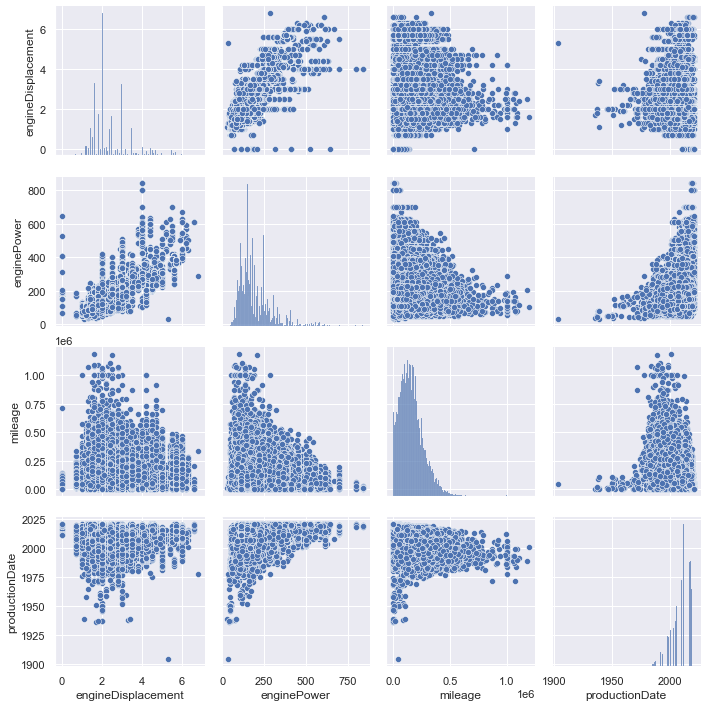

In [98]:
sns.set()
sns.pairplot(data[num_cols])

In [99]:
data[num_cols].describe()

engineDisplacement    enginePower       mileage  productionDate
count       102873.000000  102873.000000  1.028730e+05   102873.000000
mean             2.409257     189.229623  1.622763e+05     2009.859273
std              0.964452      91.966665  1.047228e+05        7.509304
min              0.000000      30.000000  1.000000e+00     1904.000000
25%              1.800000     125.000000  8.700000e+04     2006.000000
50%              2.000000     166.000000  1.480000e+05     2011.000000
75%              3.000000     235.000000  2.180000e+05     2015.000000
max              6.800000     843.000000  1.190000e+06     2021.000000

По построенным распределениям и статистикам числовых показателей можно заметить, что все распределения смещены, перед обучением модели надо попробовать сгладить распределение.

> Посмотрим корреляцию

<AxesSubplot:>

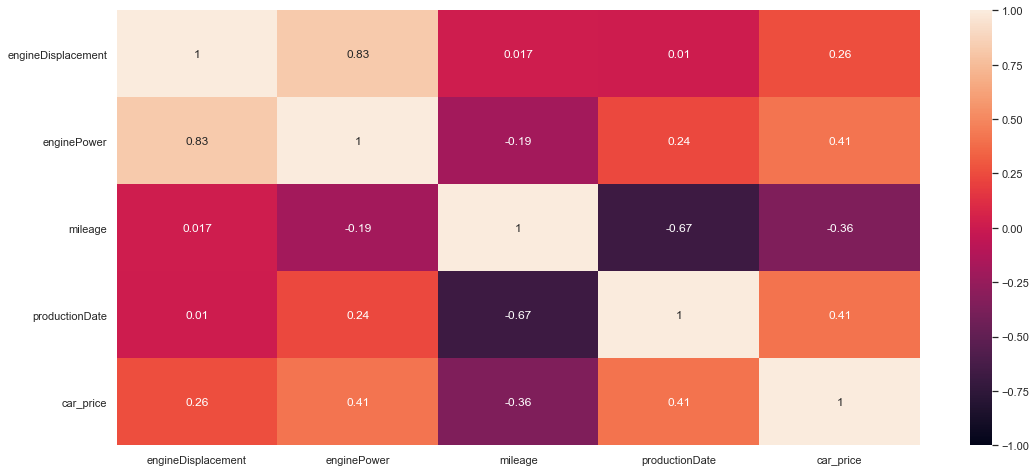

In [100]:
f, ax = plt.subplots(figsize=(18, 8))
corr_data = data[num_cols + ['car_price']].corr()
sns.heatmap(corr_data, vmin=-1, vmax=1, annot=True)

Высокая корреляция между engineDisplacement  и enginePower: 0.84, удалим engineDisplacement 

In [101]:
data.drop('engineDisplacement', axis=1, inplace=True)

In [102]:
num_cols.remove('engineDisplacement')

### Категориальные признаки 


In [103]:
data.columns

Index(['bodyType', 'brand', 'color', 'enginePower', 'fuelType', 'mileage',
       'model_name', 'productionDate', 'sell_id', 'vehicleTransmission',
       'vendor', 'owners', 'vehicle_licence', 'driving_gear', 'steering_wheel',
       'condition', 'customs', 'car_price', 'sample'],
      dtype='object')

In [104]:
len(data.columns)

19

In [105]:
num_cols

['enginePower', 'mileage', 'productionDate']

In [106]:
bin_cols = ['customs', 'condition', 'vendor','steering_wheel','vehicle_licence']
cat_cols = ['driving_gear','owners','model_name','vehicleTransmission','bodyType', 'brand', 'color','fuelType']
help_cols = ['sample', 'sell_id']
target_cols = ['car_price']
all_cols = bin_cols + num_cols + cat_cols + help_cols + target_cols
len(all_cols)

19

customs


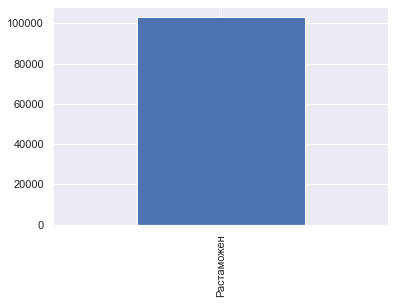

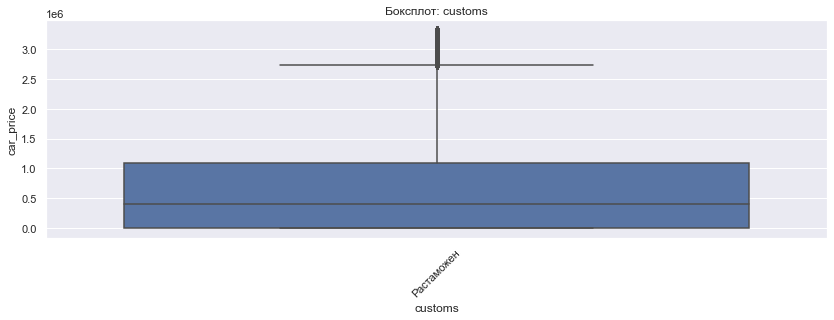

condition


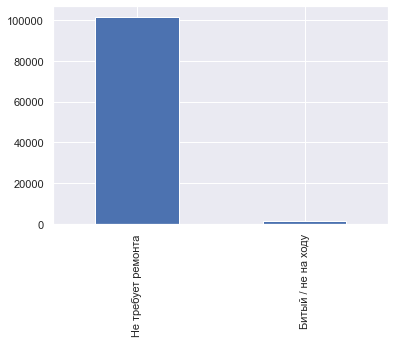

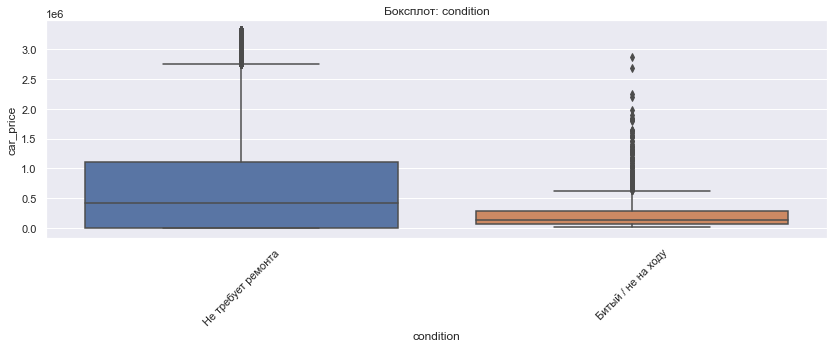

vendor


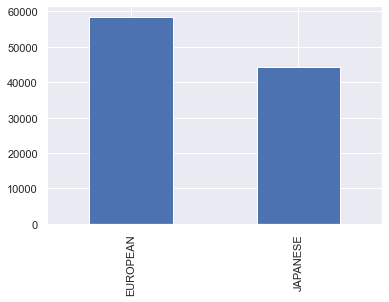

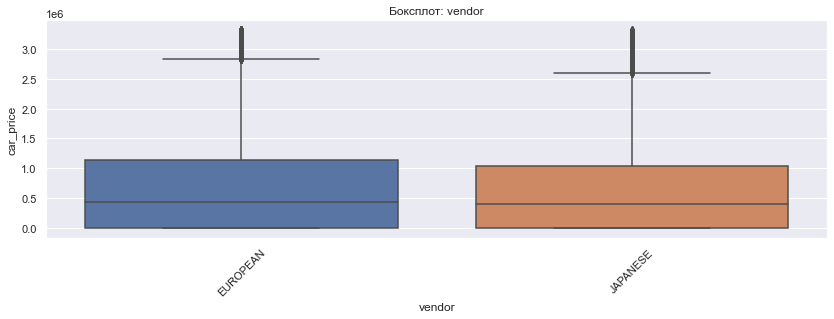

steering_wheel


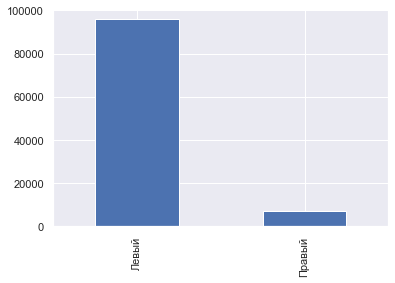

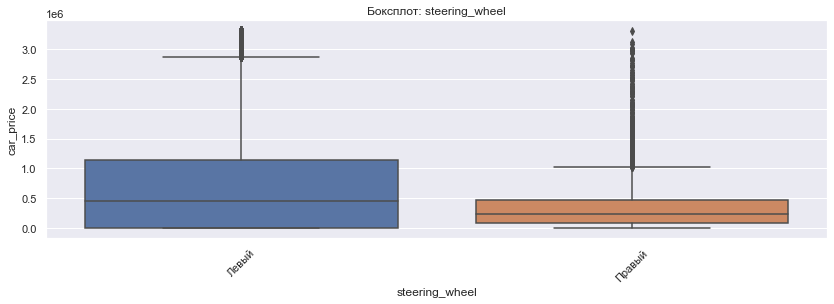

vehicle_licence


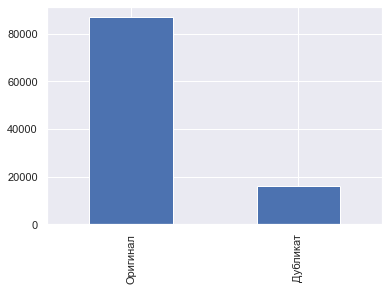

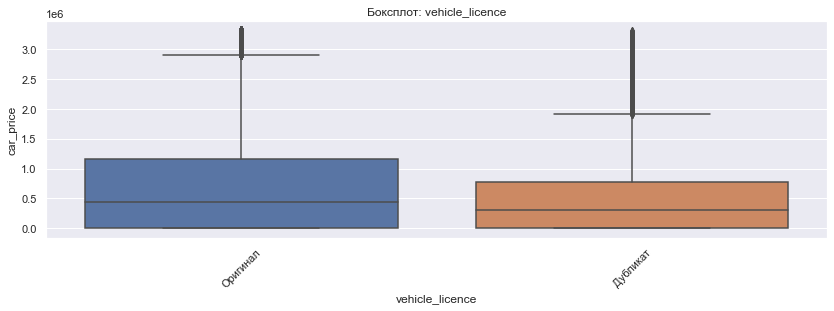

driving_gear


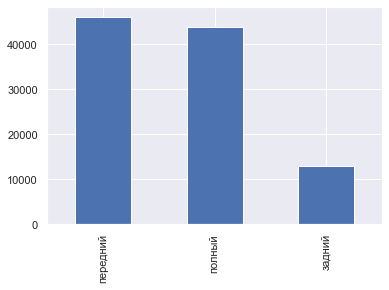

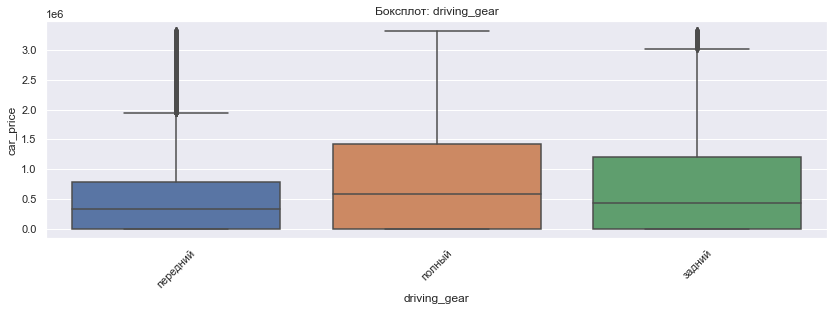

owners


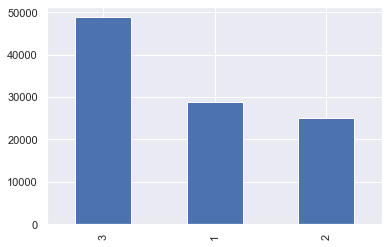

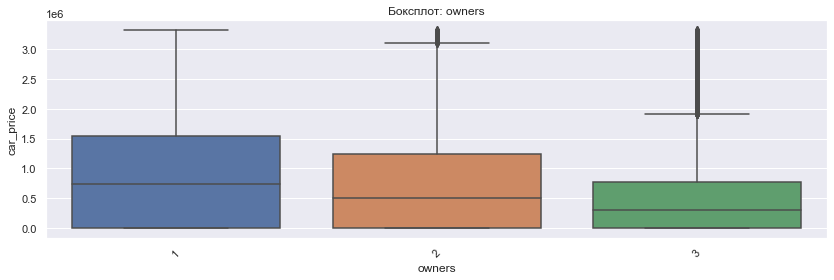

vehicleTransmission


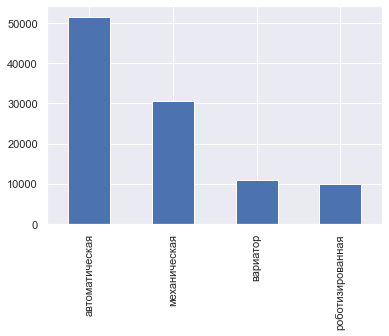

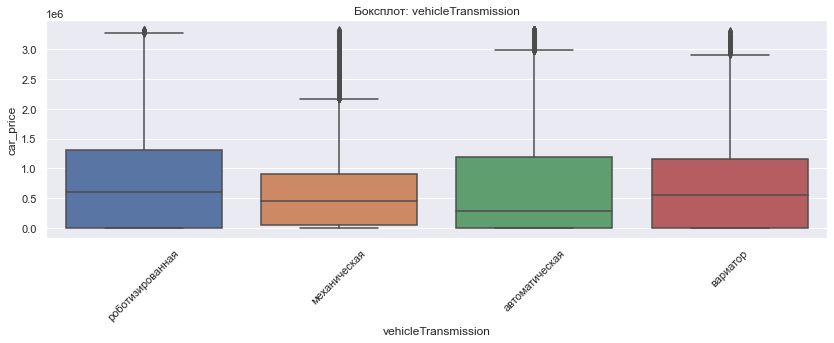

bodyType


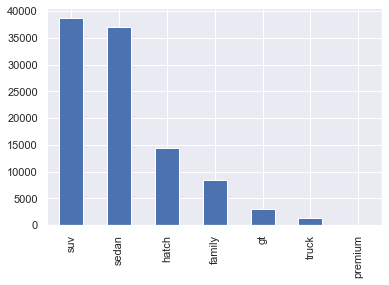

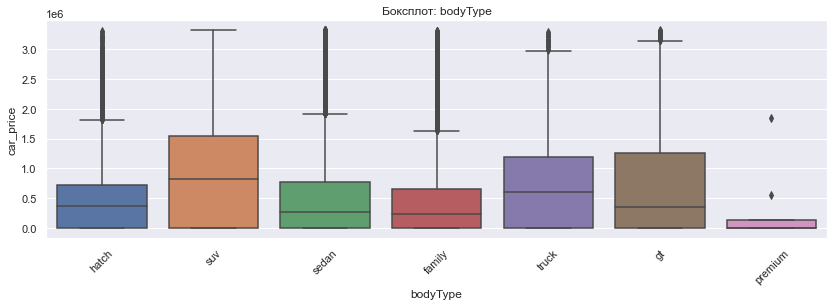

brand


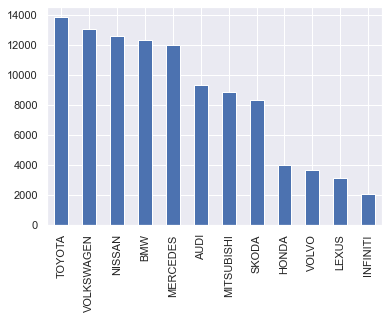

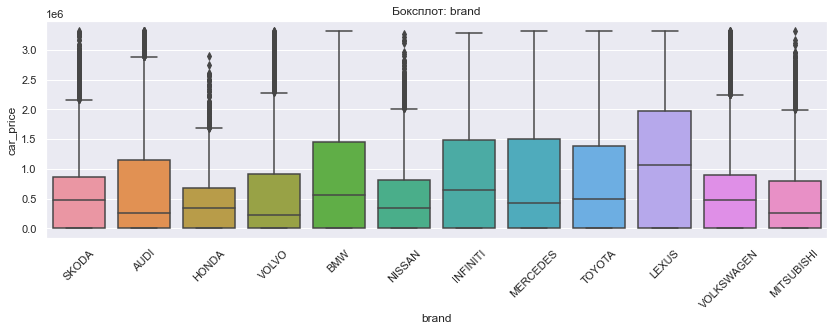

color


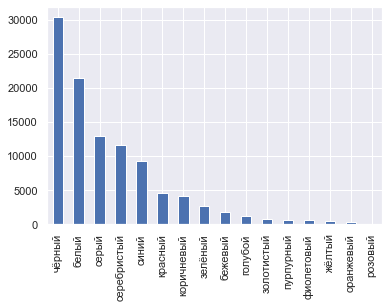

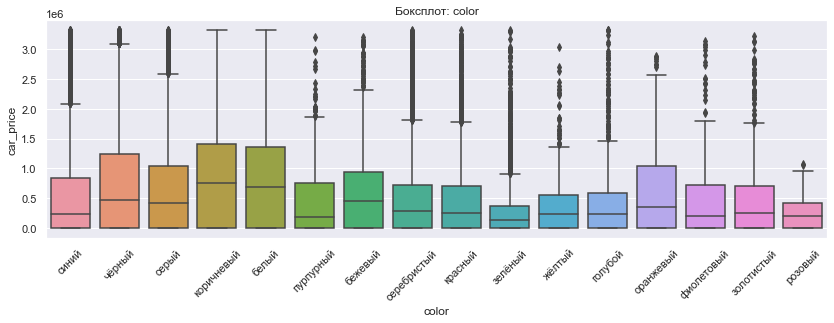

fuelType


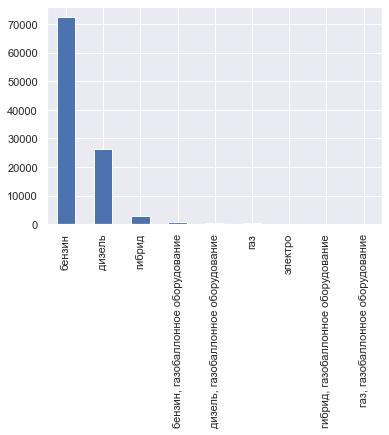

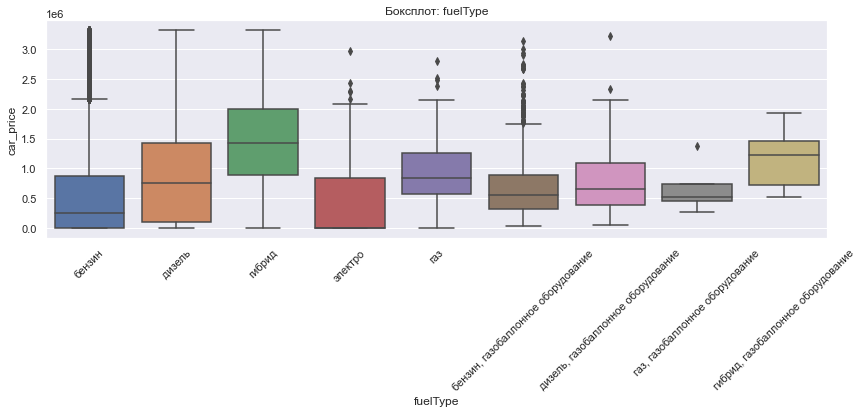

In [107]:
# чтобы сохранить читаемость графиков урежем немного распределение, до 0,95 %
for col in bin_cols + cat_cols:
    if col not in ['model_name']:
        print(col)
        data[col].value_counts().plot(kind='bar')
        get_boxplot(data = data[data.car_price <= data.car_price.quantile(0.95)], column=col, target='car_price')
    
  

- 'condition'  - не сбалансирован
- 'customs'   - в нашей выборке не представлено нерастаможенных машин, можно удалить как неинформативный ?
- 'steering_wheel' - не сбалансирован, авто с левым рулем оцениваются выше правосторонних, что логично для нашего рынка
- 'vendor' - относительно сбалансирован
- 'vehicle_licence'  - немного разбалансирован
- 'body_type' - вариативный несбалансированный, можно построить признак, выделив несколько верхних значений
- 'brand' - вариативный несбалансированный, также можно выделить 3 топ бренда
- 'color' - вариативный несбалансированный, также выделим топ 3.
- 'fuelTtype' - подавляющее количество машин - бензиновые, но очевидно, дизельные, гибридные, и, логично, электро демонстрируют более высокие цены.
- 'driving_gear' - полноприводные машины  более высоки в цене. 
- 'owners' - более высокие цены демонстрируют группы с 1 и 2 хозяевами, абсолютно новых машин в данных нет 
- 'vehicleTransmission'  - конкретный тип автоматической коробки передач не сильно определяет цену. 


### Анализ показателя цены 

посмотрим распределение 

Распределение показателя цены


<AxesSubplot:>

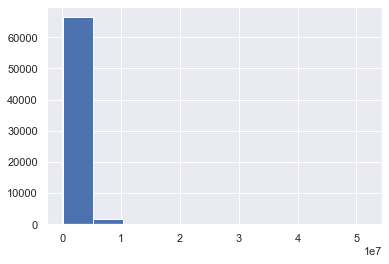

In [108]:
print('Распределение показателя цены')
data.query('sample == 1').car_price.hist()


### Создание новых признаков

> На основе числовых признаков 

- productionDate

In [109]:
data.productionDate.describe()

count    102873.000000
mean       2009.859273
std           7.509304
min        1904.000000
25%        2006.000000
50%        2011.000000
75%        2015.000000
max        2021.000000
Name: productionDate, dtype: float64

В выборке есть редкости 1904 года выпуска! в среднем, к антиквариату относят вещи не менее 50-летнего возраста, посмотрим, сколько таких машин представлено.

In [110]:
oldies = data[data.productionDate < 1970]
oldies

bodyType       brand        color  enginePower fuelType  mileage  \
1777      hatch       SKODA       чёрный         30.0   бензин    14000   
3174      sedan        AUDI       чёрный         75.0   бензин    90000   
8627      sedan         BMW        серый        150.0   бензин   200000   
9143      sedan         BMW       чёрный         51.0   бензин    44100   
9373      sedan         BMW       чёрный         51.0   бензин    88000   
9495      sedan         BMW       чёрный         46.0   бензин    25000   
9625      sedan         BMW      бежевый         51.0   бензин    16000   
9819      sedan         BMW       чёрный         46.0   бензин     4500   
15806        gt    MERCEDES       чёрный        160.0   бензин     6292   
15808        gt    MERCEDES  серебристый        120.0   бензин    58726   
16665     sedan    MERCEDES        белый        140.0   бензин    93089   
16891     sedan    MERCEDES      красный         38.0   бензин        1   
16944        gt    MERCEDES        белый         32.0   бензин    48000   
17067        gt    MERCEDES        белый        150.0   бензин    70000   
17350        gt    MERCEDES      красный        105.0   бензин    10000   
17639        gt    MERCEDES        белый        105.0   бензин    39200   
17643        gt    MERCEDES  серебристый        120.0   бензин     5000   
17653        gt    MERCEDES        серый        120.0   бензин    38000   
17796     sedan    MERCEDES       чёрный        115.0   бензин     1000   
17993        gt    MERCEDES      бежевый        120.0   бензин    56000   
18014        gt    MERCEDES    пурпурный        105.0   бензин    62300   
18129        gt    MERCEDES   коричневый        120.0   бензин     1000   
18185        gt    MERCEDES   золотистый        150.0   бензин    45200   
24597        gt  VOLKSWAGEN        синий         40.0   бензин    50000   
33748     sedan         BMW   коричневый         46.0   бензин       10   
40131     sedan        AUDI       чёрный         75.0   бензин    11000   
43244     sedan       VOLVO        серый        131.0   бензин     1000   
45410     sedan         BMW        синий        140.0   бензин     1000   
45715     sedan         BMW      бежевый         46.0   бензин     6000   
45915     sedan         BMW       чёрный         51.0   бензин    47000   
45951     sedan         BMW      красный         51.0   бензин    50000   
50828        gt    MERCEDES  серебристый        120.0   бензин    68000   
52484     sedan    MERCEDES        серый        160.0   бензин   108000   
52863     sedan    MERCEDES       чёрный         38.0   бензин   100000   
52899        gt    MERCEDES   коричневый        120.0   бензин     1000   
52960        gt    MERCEDES      красный        150.0   бензин    45000   
53011        gt    MERCEDES      красный        105.0   бензин     9000   
53044        gt    MERCEDES        белый        105.0   бензин    46000   
53047        gt    MERCEDES      бежевый        170.0   бензин    51000   
53050        gt    MERCEDES  серебристый        120.0   бензин    45000   
53217     sedan    MERCEDES      бежевый         88.0   дизель    64000   
67812     sedan         BMW   коричневый         46.0   бензин     1000   
69985     sedan    MERCEDES       чёрный        115.0   бензин    18000   
75247     sedan         BMW       чёрный         46.0   бензин    10000   
75719     sedan         BMW       чёрный         46.0   бензин   108000   
77261        gt    MERCEDES      зелёный        160.0   бензин    77000   
77267        gt    MERCEDES       чёрный        105.0   бензин     6000   
79760        gt  VOLKSWAGEN      красный         44.0   бензин     1000   
84918        gt    MERCEDES        белый         80.0   бензин     1000   
86134     sedan       SKODA  серебристый         45.0   бензин     1000   
98059     sedan    MERCEDES      зелёный         40.0   бензин    19000   
99073     sedan         BMW      красный         46.0   бензин     1000   
106905  premium    MERCEDES     

In [111]:
len(oldies)

53

добавим признак винтажности авто 

In [112]:
data['vintage'] = data.productionDate.apply(lambda x: 1 if x < 1970 else 0 )

Из факторов влияния на цену традиционно выделяются два этапа значительного понижения цены - 3 года после выпуска и 5 лет после выпуска. Добавим эти два признака. 

In [113]:
now = datetime.datetime.now()
year = now.year

In [114]:
data['older_3_years'] = data.productionDate.apply(lambda x: 1 if x < year - 3 else 0)
data['older_5_years'] = data.productionDate.apply(lambda x: 1 if x < year - 5 else 0)

In [115]:
bin_cols.extend(['vintage', 'older_3_years', 'older_5_years'])


- mileage

In [116]:
data['miles_year'] = round(data['mileage'] / (year - data['productionDate']), -3)

In [117]:
data.miles_year

0         11000.0
1         15000.0
2         13000.0
3         14000.0
4          7000.0
           ...   
112208     2000.0
112209        inf
112210        inf
112211     9000.0
112212        inf
Name: miles_year, Length: 102873, dtype: float64

In [118]:
data['miles_year'].replace([np.inf, -np.inf], 0, inplace=True)


In [119]:
data.miles_year

0         11000.0
1         15000.0
2         13000.0
3         14000.0
4          7000.0
           ...   
112208     2000.0
112209        0.0
112210        0.0
112211     9000.0
112212        0.0
Name: miles_year, Length: 102873, dtype: float64

Распределение показателя годового пробега


<AxesSubplot:>

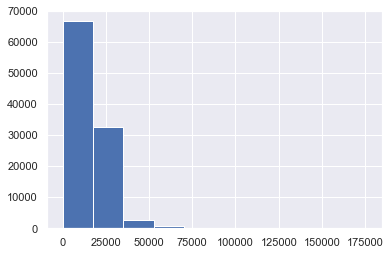

In [120]:
print('Распределение показателя годового пробега')
data.miles_year.hist()

<AxesSubplot:>

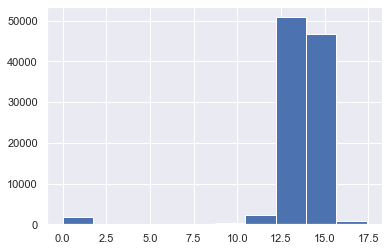

In [121]:
np.log2(data.miles_year + 1).hist() 

In [122]:
#добавим новым признаком 
data['miles_year_log2'] = np.log2(data.miles_year + 1)


> bodyType

In [123]:
# Выделим популярные типы кузова
data['bodyType_top'] = data.bodyType.apply(lambda x: 1 if x in ['внедорожник', 'кабриолет', 'пикап'] else 0) 

In [124]:
#уменьшим количество категорий для bodytype 
data['bodyType'] = data.bodyType.apply(lambda x: get_types(x)) # сделано выше

> color

In [125]:
# выделим популярные цвета 
data['color_top'] = data.color.apply(lambda x: 1 if x in ['белый', 'коричневый'] else 0)

> driving_gear

In [126]:
# выделим популярный тип привода
data['driving_gear_top'] = data.driving_gear.apply(lambda x: 1 if x in ['полный'] else 0)

> Рассмотрим и удалим выбросы в числовых показателях

In [127]:
for col in num_cols:
    print(col)
    cut_off_stat_outliers(data, col)
    print('_'*30 + '\n')


enginePower
Количество выбросов: enginePower : 3724
Верхняя граница выбросов: 400.0 Нижняя граница выбросов: -40.0
______________________________

mileage
Количество выбросов: mileage : 2264
Верхняя граница выбросов: 414500.0 Нижняя граница выбросов: -109500.0
______________________________

productionDate
Количество выбросов: productionDate : 3326
Верхняя граница выбросов: 2028.5 Нижняя граница выбросов: 1992.5
______________________________



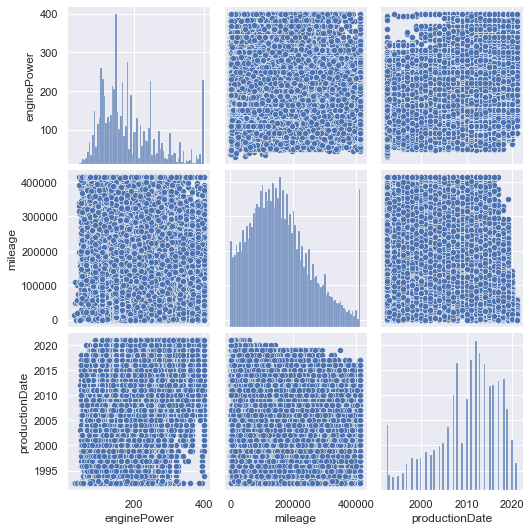

In [128]:
sns.set()
sns.pairplot(data[num_cols])

> проверка корреляции с учетом новых признаков

<AxesSubplot:>

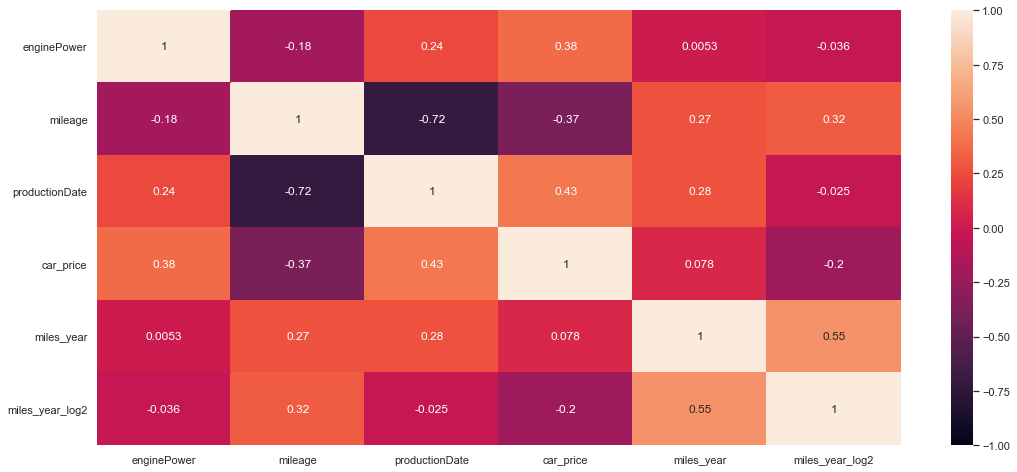

In [129]:
f, ax = plt.subplots(figsize=(18, 8))
corr_data = data[num_cols + ['car_price'] + ['miles_year'] + ['miles_year_log2']].corr()
sns.heatmap(corr_data, vmin=-1, vmax=1, annot=True)

оставим все числовые признаки

### Значимость числовых переменных `

In [130]:
num_cols

['enginePower', 'mileage', 'productionDate']

Text(0.5, 1.0, 'Значимость числовых переменных для car_price')

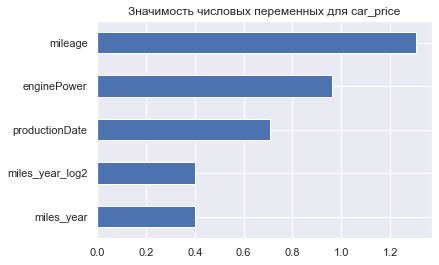

In [131]:
cols = ['enginePower', 'mileage', 'productionDate', 'miles_year', 'miles_year_log2']
imp_cat = Series(mutual_info_classif(data[data['car_price'] >0][cols], 
                                     data[data['car_price'] >0]['car_price'],
                                     discrete_features = True), index = cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')
plt.title('Значимость числовых переменных для car_price')

### Стандартизация и кодирование

In [132]:
data.columns

Index(['bodyType', 'brand', 'color', 'enginePower', 'fuelType', 'mileage',
       'model_name', 'productionDate', 'sell_id', 'vehicleTransmission',
       'vendor', 'owners', 'vehicle_licence', 'driving_gear', 'steering_wheel',
       'condition', 'customs', 'car_price', 'sample', 'vintage',
       'older_3_years', 'older_5_years', 'miles_year', 'miles_year_log2',
       'bodyType_top', 'color_top', 'driving_gear_top'],
      dtype='object')

In [133]:
len(data.columns)

27

In [134]:
num_cols = ['enginePower', 'mileage', 'miles_year','productionDate',
       'miles_year_log2']

In [135]:
bin_cols = ['customs', 'vintage', 'older_3_years', 'older_5_years',
            'vehicleTransmission', 'vendor', 'vehicle_licence', 'steering_wheel', 
            'condition', 'color_top', 'driving_gear_top', 'bodyType_top'] 

In [136]:
cat_cols = ['bodyType', 'brand', 'color', 'model_name', 'fuelType', 
        'owners',  'driving_gear']

In [137]:
all_columns = num_cols + bin_cols + cat_cols + help_cols+ target_cols


In [138]:
len(all_columns)

27

In [139]:
#scaler = StandardScaler() # неуд
#for col in num_cols:
    #brushed = scaler.fit_transform(data.loc[:,[col]])
    #data[col] = brushed

> Сгладим распределение числовых показателей

In [140]:
for col in num_cols:
    scaler = MinMaxScaler()
    income_std = scaler.fit_transform(data.loc[:,[col]])
    data[col] = income_std

> Закодируем бинарные признаки

In [141]:
#cols = ['bodyType', 'brand', 'color', 'fuelType', 'owners',  'driving_gear', 'vehicleTransmission']
for col in  cat_cols + bin_cols:    
    data[col] = data[col].astype('category').cat.codes

In [142]:
encoder = ce.BinaryEncoder(cols=['model_name'])
df_bin = encoder.fit_transform(data['model_name'])
data = pd.concat([data, df_bin], axis = 1)
data.drop('model_name', axis = 1, inplace=True)

In [143]:
data_agg = data.agg({'nunique', lambda s: s.unique()[:10]})\
    .append(pd.Series(data.isnull().sum(), name='null'))\
    .append(pd.Series(data.dtypes, name='dtype'))\
    .transpose()
data_agg

<lambda>  \
bodyType                                         [2, 5, 4, 0, 6, 1, 3]   
brand                                  [8, 0, 2, 11, 1, 7, 3, 5, 9, 4]   
color                               [13, 15, 12, 6, 1, 9, 0, 11, 7, 4]   
enginePower          [0.2027027027027027, 0.21621621621621623, 0.32...   
fuelType                                   [0, 6, 4, 8, 2, 1, 7, 3, 5]   
mileage              [0.17852636556421125, 0.14610891702995665, 0.2...   
productionDate       [0.7543859649122737, 0.8596491228070136, 0.684...   
sell_id              [1100575026.0, 1100549428.0, 1100658222.0, 110...   
vehicleTransmission                                       [3, 2, 0, 1]   
vendor                                                          [0, 1]   
owners                                                       [2, 0, 1]   
vehicle_licence                                                 [1, 0]   
driving_gear                                                 [1, 2, 0]   
steering_wheel                                                  [0, 1]   
condition                                                       [1, 0]   
customs                                                            [0]   
car_price            [0.0, 1438000.0, 1281000.0, 250000.0, 625000.0...   
sample                                                          [0, 1]   
vintage                                                         [0, 1]   
older_3_years                                                   [1, 0]   
older_5_years                                                   [1, 0]   
miles_year           [0.06249999999999999, 0.08522727272727272, 0.0...   
miles_year_log2      [0.7704547714321355, 0.7961315720702907, 0.784...   
bodyType_top                                                       [0]   
color_top                                                       [0, 1]   
driving_gear_top                                                [0, 1]   
model_name_0                                                    [0, 1]   
model_name_1                                                    [0, 1]   
model_name_2                                                    [0, 1]   
model_name_3                                                    [0, 1]   
model_name_4                                                    [0, 1]   
model_name_5                                                    [0, 1]   
model_name_6                                                    [0, 1]   
model_name_7                                                    [0, 1]   
model_name_8                                                    [0, 1]   
model_name_9                                                    [1, 0]   

                    nunique null    dtype  
bodyType                  7    0     int8  
brand                    12    0     int8  
color                    16    0     int8  
enginePower             291    0  float64  
fuelType                  9    0     int8  
mileage               11081    0  float64  
productionDate           30    0  float64  
sell_id               98785    0  float64  
vehicleTransmission       4    0     int8  
vendor                    2    0     int8  
owners                    3    0     int8  
vehicle_licence           2    0     int8  
driving_gear              3    0     int8  
steering_wheel            2    0     int8  
condition                 2    0     int8  
customs                   1    0     int8  
car_price              1402    0  float64  
sample                    2    0    int64  
vintage                   2    0     int8  
older_3_years             2    0     int8  
older_5_years             2    0     int8  
miles_year              125    0  float64  
miles_year_log2         125    0  float64  
bodyType_top              1    0     int8  
color_top                 2    0     int8  
driving_gear_top          2    0     int8  
model_name_0              2    0    int64  
model_name_1              2    0    int64  
model_name_2              2    0    int64  
mod

data.drop(['productionDate'], axis=1, inplace=True)


## Train Split

In [144]:
train = data[data['sample'] == 1].copy()

In [145]:
train.drop('sample', axis = 1, inplace=True )

In [146]:
X = train.drop('car_price', axis = 1)

In [147]:
y = train.car_price.values

In [148]:
X_sub = data[data['sample'] == 0].copy()
X_sub.drop(['sample', 'car_price'], axis = 1, inplace=True )

In [149]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

# Наивная модель
Эта модель будет предсказывать среднюю цену по мощности двигателя (enginePower). 
C ней будем сравнивать другие модели.




In [150]:
tmp_train = train.copy()
y_train_tmp = y.copy()

In [151]:
# Находим median по экземплярам enginePower в трейне и размечаем тест
predict = X_test['enginePower'].map(tmp_train.groupby('enginePower')['car_price'].median())

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(y_test, predict.values))*100:0.2f}%")
#84.77%

Точность наивной модели по метрике MAPE: 84.82%


#  Модель CatBoost

In [152]:
model = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )

In [153]:
model.fit(X_train, y_train,
         #cat_features=cat_cols,
         eval_set=(X_test, y_test),
         verbose_eval=0,
         use_best_model=True,
         plot=True
         )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [154]:
predict = model.predict(X_test)
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")
#Точность модели по метрике MAPE: 20.90%
#Точность модели по метрике MAPE: 20.83%

Точность модели по метрике MAPE: 21.40%


#### Логарифмирование таргета и подбор параметров

Попробуем взять таргет в логарифм - это позволит уменьшить влияние выбросов на обучение модели (используем для этого np.log и np.exp).    


In [155]:
model = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True)

In [156]:
model.fit(X_train, np.log(y_train))

In [157]:
predict_model = np.exp(model.predict(X_test))

In [158]:
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_model))*100:0.2f}%")
#Точность модели по метрике MAPE: 17.49%


Точность модели по метрике MAPE: 17.88%


#### Подбор параметров

In [159]:
cb_model = CatBoostRegressor(iterations=5000, 
                             random_seed=RANDOM_SEED, 
                             eval_metric='MAPE', 
                             custom_metric=['R2', 'MAE'], 
                             silent=True, depth=12, 
                             random_strength=0.3, 
                             learning_rate=0.15, 
                             l2_leaf_reg=7.5)

In [160]:
cb_model.fit(X_train, np.log(y_train),
         #cat_features=cat_cols,
         eval_set=(X_test, np.log(y_test)),
         verbose_eval=0,
         use_best_model=True,
         #plot=True
         )

# cb_model.save_model('catboost_single_model_opt.model')

In [161]:
predict_test = np.exp(cb_model.predict(X_test))
#predict_submission = np.exp(model.predict(X_sub))

In [162]:
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

# catboost from the box 17.42%
# binary encoding model_name: 17.27%
# подбор параметров по сетке: 17.66%
# коррекция инфляции 1,29: 17.59%

Точность модели по метрике MAPE: 17.65%


## Модель ExtraTrees¶
В данном классе реализован метаоценщик, использует усреднение для повышения точности прогнозирования

In [163]:
xtr = ExtraTreesRegressor(n_estimators=300,
                         criterion='mse',
                         n_jobs=-1, 
                          # warm_start=True,
                         random_state=RANDOM_SEED)

In [164]:
xtr.fit(X_train, y_train)

ExtraTreesRegressor(n_estimators=300, n_jobs=-1, random_state=42)

In [165]:
xtr_predict = xtr.predict(X_test)

In [166]:
print(f"Точность модели по метрике MAPE: {(mape(y_test, xtr_predict))*100:0.2f}%")
#22.18%
# 22,14
# binary_encoding model_name: 21.13
# Точность модели по метрике MAPE: 21.04%

Точность модели по метрике MAPE: 21.24%


## Модель RANDOM FOREST

In [167]:
random_grid = {'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 400, num = 4)],
               'max_features': ['auto', 'sqrt'],
               'max_depth': [int(x) for x in np.linspace(5, 15, num = 6)] + [None],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False]}

In [168]:
best_rfr = RandomForestRegressor(random_state=RANDOM_SEED
                      , n_estimators=200
                      , min_samples_split=5
                      , min_samples_leaf=1
                      , max_features='auto'
                      , max_depth=15
                      , bootstrap=True)

In [169]:
best_rfr.fit(X_train, np.log(y_train))

RandomForestRegressor(max_depth=15, min_samples_split=5, n_estimators=200,
                      random_state=42)

In [170]:
predict_rfr = np.exp(best_rfr.predict(X_test))

In [171]:
print(f'Точность модели по метрике MAPE:{(mape(y_test, predict_rfr))*100:0.2f}%')
# Точность модели по метрике MAPE:18.06%
# Точность модели по метрике MAPE:18.04%

Точность модели по метрике MAPE:18.42%


In [172]:
rfr = RandomForestRegressor(n_estimators=300, n_jobs=-1, random_state=RANDOM_SEED)

In [173]:
rfr.fit(X_train, y_train)

RandomForestRegressor(n_estimators=300, n_jobs=-1, random_state=42)

In [174]:
predict = rfr.predict(X_test)


In [175]:
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")
# binary_encoder model_name: 21.63
# Точность модели по метрике MAPE: 21.60%
# Точность модели по метрике MAPE: 21.59%

Точность модели по метрике MAPE: 22.17%


#  Стэкинг 

Выбирем для стека самые лучшие модели, которые мы получили: RandomForest, CatBoosting. Для обработки результатов возьмем линейную регрессию. 

In [176]:
estimators = [('model', CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          #custom_metric=['R2', 'MAE'],
                          silent=True)),
               ('best_rfr', RandomForestRegressor(random_state=RANDOM_SEED
                      , n_estimators=200
                      , min_samples_split=5
                      , min_samples_leaf=1
                      , max_features='auto'
                      , max_depth=15
                      , bootstrap=True))]

In [177]:
st_ensemble = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())

In [178]:
# обучение
st_ensemble.fit(X_train, np.log(y_train))

StackingRegressor(estimators=[('model',
                               <catboost.core.CatBoostRegressor object at 0x00000198D970BF10>),
                              ('best_rfr',
                               RandomForestRegressor(max_depth=15,
                                                     min_samples_split=5,
                                                     n_estimators=200,
                                                     random_state=42))],
                  final_estimator=LinearRegression())

In [179]:
X_test.shape

(13638, 34)

In [180]:
X_sub.columns

Index(['bodyType', 'brand', 'color', 'enginePower', 'fuelType', 'mileage',
       'productionDate', 'sell_id', 'vehicleTransmission', 'vendor', 'owners',
       'vehicle_licence', 'driving_gear', 'steering_wheel', 'condition',
       'customs', 'vintage', 'older_3_years', 'older_5_years', 'miles_year',
       'miles_year_log2', 'bodyType_top', 'color_top', 'driving_gear_top',
       'model_name_0', 'model_name_1', 'model_name_2', 'model_name_3',
       'model_name_4', 'model_name_5', 'model_name_6', 'model_name_7',
       'model_name_8', 'model_name_9'],
      dtype='object')

In [181]:
#предсказание  
predict_e = np.exp(st_ensemble.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_e))*100:0.2f}%")
#Точность модели по метрике MAPE: 17.19%

Точность модели по метрике MAPE: 17.56%


In [182]:
predict_submission = np.exp(st_ensemble.predict(X_sub)).astype(int)

In [183]:
predict_submission = np.around(predict_submission)

# Submission

In [184]:
sample_submission['price'] = predict_submission
sample_submission.to_csv(f'submission_6.csv', index=False)
sample_submission.head(10)

sell_id    price
0  1100575026   776509
1  1100549428  1111301
2  1100658222  1033040
3  1100937408   811382
4  1101037972   778522
5  1100912634   712627
6  1101228730   812402
7  1100165896   496710
8  1100768262  2214717
9  1101218501   984577

## Выводы:


Работа над проектом выполнена в несколько этапов: 

1. Получение данных для обучения модели. 

    Парсингом получено более 77 000 актуальных записей с сайта *auto.ru.* 
   
2. Исследование и первичная обработка данных: 

    * слияние данных;
    * очистка и избавление от пропусков; 
    * проведена работа с выбросами; 
    * очистка от дубликатов;
    * нормализация цифровых признаков; 
    * корреляционный анализ и анализ значимости признаков для прогнозирования целевого показателя.
    
3. Создание новых и изменение имеющихся признаков:  
    * созданы дополнительные признаки, показавшие большое влияние на точность предсказания, 
    * проведено бинарное и лейбл-кодирование категориальных переменных, улучшившие качество прогноза,

4. Протестированы следующие модели: 

        CatBoostRegressor, 
        RandomForestRegressor,  
        ExtraTreesRegressor, 
        ансамбль моделей. 
        Проведен подбор оптимальных параметров. 

## Направления для дальнейшего улучшения качества предсказания: 

1. Парсинг дополнительных данных, до показателя в  140 000 наблюдений. 
2. Детальный контроль непересечения данных в тестовой и обучающей выборках. 
3. Работа со словарями дополнительного оборудования и комплектации, значимо влияющих на цену автомобиля. 
4. Более детальная работа с показателями инфляции для приведения пространства обучающих и тестовых данных к одному масштабу.